In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# EDA

In [2]:
data = pd.read_csv(f'/kaggle/input/student-final-grade-prediction-multi-lin-reg/student-mat.csv')

In [3]:
data.head(5)

,school,sex,age,address,famsize,Parrent_status,Mother_edu,Father_edu,Mother_job,Father_job,...,Family_quality_reln,freetime_after_school,goout_with_friends,workday_alcohol_consum,weekend_alcohol_consum,health_status,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
data.isnull().sum()

school                      0
sex                         0
age                         0
address                     0
famsize                     0
Parrent_status              0
Mother_edu                  0
Father_edu                  0
Mother_job                  0
Father_job                  0
reason_to_chose_school      0
guardian                    0
traveltime                  0
weekly_studytime            0
failures                    0
extra_edu_supp              0
family_edu_supp             0
extra_paid_class            0
extra_curr_activities       0
nursery                     0
Interested_in_higher_edu    0
internet_access             0
romantic_relationship       0
Family_quality_reln         0
freetime_after_school       0
goout_with_friends          0
workday_alcohol_consum      0
weekend_alcohol_consum      0
health_status               0
absences                    0
G1                          0
G2                          0
G3                          0
dtype: int

<Axes: >

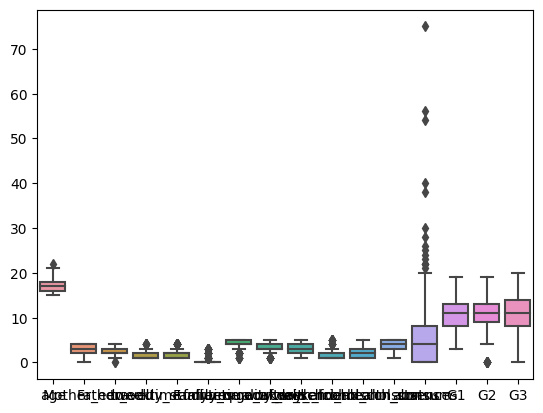

In [5]:
sns.boxplot(data)

# Data Preparation

In [6]:
def encoder(data):
    encoder = LabelEncoder()
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = encoder.fit_transform(data[col])
    return data

In [7]:
data = encoder(data)

In [8]:
def normalizer(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    for col in data.columns:
        data[col] = data[col].apply(lambda x: upper_bound[col] if x > upper_bound[col] else (lower_bound[col] if x < lower_bound[col] else x))
    return data

In [9]:
data = normalizer(data)

In [10]:
def scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Model Building

In [11]:
X = data.drop(columns='G3')
y = data['G3']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [13]:
X_train_scaled, X_test_scaled = scaler(X_train, X_test)

In [14]:
model = ElasticNet(alpha=1)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],        # Regularization strength
    'l1_ratio': [0.1, 0.5, 0.9, 1.0]        # Mix ratio between Lasso (L1) and Ridge (L2)
}
grid_search = GridSearchCV(estimator=model, cv=5, param_grid=param_grid)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print(f'Best Parameters:\n{best_params}')

Best Parameters:
{'alpha': 0.1, 'l1_ratio': 1.0}


In [15]:
best_model = grid_search.best_estimator_

In [16]:
y_pred = best_model.predict(X_test_scaled)

In [17]:
MSE = mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

In [18]:
print(f'R2:\n{R2*100:.0f}%\nMSE:\n{MSE:.2f}')

R2:
79%
MSE:
4.40


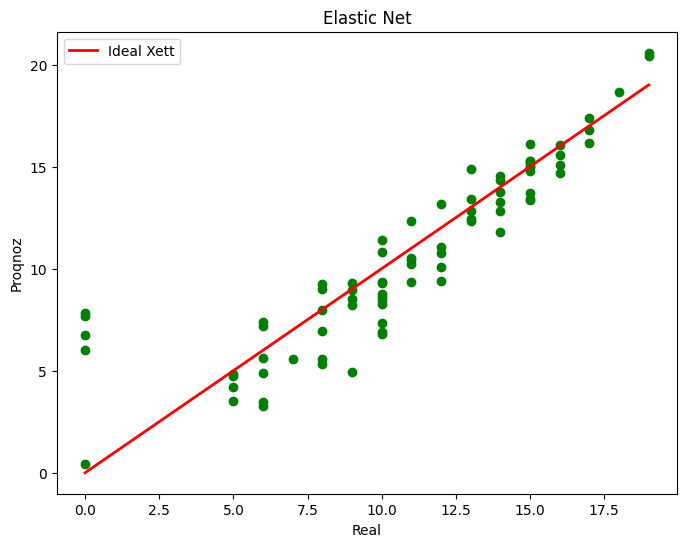

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(y_test,y_pred, c='g')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linewidth=2, label='Ideal Xett')
plt.title('Elastic Net')
plt.xlabel('Real')
plt.ylabel('Proqnoz')
plt.legend()
plt.show()